In [20]:
%pip install pystac_client fsspec xarray h5py requests aiohttp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install scipy netCDF4 h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [23]:
from pystac_client import Client
import fsspec
import xarray as xr
import h5py
import seaborn as sns
from ectools import ecio
from ectools import ecplot as ecplt

In [24]:
token = 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJQXzJqUU50Y3QtOGR2cW1qVG5QWDVNc3BfT1Zid2lzVFlHbmFwM2tUWVdJIn0.eyJleHAiOjE3NDcyNDk2NjYsImlhdCI6MTc0NzIxMzY2NiwianRpIjoiMGNjMzdkNDAtZDM1YS00MmMzLWJlZWMtODVhNGRiNWY4YzBiIiwiaXNzIjoiaHR0cHM6Ly9pYW0ubWFhcC5lby5lc2EuaW50L3JlYWxtcy9lc2EtbWFhcCIsInN1YiI6IjhhYjZmMWMyLWUzYmUtNDAyNC04YTBlLTg2YWMxZmViOGI3ZiIsInR5cCI6IkJlYXJlciIsImF6cCI6ImJpby1wZGdzLXN5cy11c2VycyIsInNpZCI6IjYwMzk3YjQ1LTQ2MDYtNGYyOS1hYWM2LTIzYTVkYmIxYzcyMSIsInNjb3BlIjoib3BlbmlkIiwiZ3JvdXBzIjpbIi9jb2xsZWN0aW9ucy9CSU9NQVNTLVBER1MvQmlvbWFzc0F1eCIsIi9jb2xsZWN0aW9ucy9CSU9NQVNTLVBER1MvQmlvbWFzc0F1eElPQyIsIi9jb2xsZWN0aW9ucy9CSU9NQVNTLVBER1MvQmlvbWFzc0F1eFJlc3QiLCIvY29sbGVjdGlvbnMvQklPTUFTUy1QREdTL0Jpb21hc3NMZXZlbDAiLCIvY29sbGVjdGlvbnMvQklPTUFTUy1QREdTL0Jpb21hc3NMZXZlbDBJT0MiLCIvY29sbGVjdGlvbnMvQklPTUFTUy1QREdTL0Jpb21hc3NMZXZlbDFhIiwiL2NvbGxlY3Rpb25zL0JJT01BU1MtUERHUy9CaW9tYXNzTGV2ZWwxYUlPQyIsIi9jb2xsZWN0aW9ucy9CSU9NQVNTLVBER1MvQmlvbWFzc0xldmVsMWIiLCIvY29sbGVjdGlvbnMvQklPTUFTUy1QREdTL0Jpb21hc3NMZXZlbDFiSU9DIiwiL2NvbGxlY3Rpb25zL0JJT01BU1MtUERHUy9CaW9tYXNzTGV2ZWwxYyIsIi9jb2xsZWN0aW9ucy9CSU9NQVNTLVBER1MvQmlvbWFzc0xldmVsMWNJT0MiLCIvY29sbGVjdGlvbnMvQklPTUFTUy1QREdTL0Jpb21hc3NMZXZlbDJhIiwiL2NvbGxlY3Rpb25zL0JJT01BU1MtUERHUy9CaW9tYXNzTGV2ZWwyYUlPQyIsIi9leHBsb3JlciJdfQ.ZqKwa0cMB6lqslOIZ741HItTdNaoXjcVG9FnmfozKX-Yvw2zafoXufEIxBPIK9vm1s33LHQQjuSqBPC6hr2n07cf2kImxh8ZHLujuJHMafpUDgtqApYrHa9bQqlCF7-XT4N_Qlp7IfUAN5--JLVHVuFS0uzPfcjHAWljRj69iX0AJOIfOD7KR5KTo_GPB3ctFvGNgb1qfI5T_cS0EUDjzD5iudJMO8pNGTDfHm-RwB_hPM5iVbk312drjA4k866F1GxqOtBXXqXyuTjhfxiwv-AaaZxdCGLBW2y8U6Ttea1bBKYZ3R9XvNGHQJsq2EWW-ZUCROt9umASZeoOTelXtg'

#### Navigate the catalog and filter

In [25]:
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

If you are curious about more queryables / filtering options:
`curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections/EarthCAREL2InstChecked_MAAP/queryables`
or visit: https://catalog.maap.eo.esa.int/doc/stac.html#granule-search 

In [26]:
search = catalog.search(
    collections=["EarthCAREL2InstChecked_MAAP"], # Currently MAAP has access to this L2 collection 

    filter="productType = 'AC__TC__2B' and orbitNumber = 01394 and (frame = 'E' or frame = 'D')", # Filter by product type


    #datetime=['2025-04-01T12:47:51.000Z', '2025-04-02T12:47:51.000Z'], # filter by temporal extent 
    
    #bbox = [-8, 42, 5, 47] or [9, 43, 23, 47], # combine multiple bbox by OR 
    # bounding box is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax) 

    max_items=10  # Adjust as needed
)

items = list(search.items())
results = dict() # or just {} 
id_lst = []
href_lst = []
for item in items:
    id_lst.append(item.id)
    href_lst.append(item.assets["enclosure_1"].href)

for i, j in zip(id_lst, href_lst):
    results.update({i: j})


In [27]:
print(len(items))

2


In [38]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
href = href_lst[1]
with fs.open(href, "rb") as f:
    print(f)
    #ecio.load_ACTC(f)
    with xr.open_dataset(f, engine="h5netcdf", group="ScienceData") as ds:
        ds.load()

<File-like object HTTPFileSystem, https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/AC__TC__2B/AA/2024/08/26/ECA_EXAA_AC__TC__2B_20240826T134455Z_20240826T153130Z_01394E/ECA_EXAA_AC__TC__2B_20240826T134455Z_20240826T153130Z_01394E/ECA_EXAA_AC__TC__2B_20240826T134455Z_20240826T153130Z_01394E.h5>


In [40]:
CTC_category_colors = [sns.xkcd_rgb['silver'],      #missing data
                       sns.xkcd_rgb['reddish brown'],       #surface and subsurface
                       sns.xkcd_rgb['white'],       #clear
                       sns.xkcd_rgb['pale yellow'],  #liquid cloud
                       sns.xkcd_rgb['golden'], # drizzling liquid cloud
                       sns.xkcd_rgb['orange'], # warm rain
                       sns.xkcd_rgb['bright red'],    #cold rain
                       sns.xkcd_rgb['easter purple'], # melting snow
                       sns.xkcd_rgb["prussian blue"],   # rimed snow (poss. liquid)
                       sns.xkcd_rgb['bright blue'], # snow
                       sns.xkcd_rgb['light blue'],    # ice (no liquid)
                       sns.xkcd_rgb['ice blue'],      # strat. ice
                       sns.xkcd_rgb['ugly green'],    # insects
                       sns.xkcd_rgb['dark red'],      # heavy rain likely 
                       sns.xkcd_rgb["royal blue"],   # mixed-phase precip. likely
                       sns.xkcd_rgb['dark red'],      # heavy rain
                       sns.xkcd_rgb["navy blue"],   #heavy mixed-phase precipitation
                       sns.xkcd_rgb['dull red'],     # rain in clutter 
                       sns.xkcd_rgb['off blue'],     #snow in clutter
                       sns.xkcd_rgb['dull yellow'],    # cloud in clutter 
                       sns.xkcd_rgb['light grey'],    # clear (poss. liquid) 
                       sns.xkcd_rgb['silver'],        # unknown
                      ]
ACTC_category_colors = [sns.xkcd_rgb['silver'],         #unknown
                        sns.xkcd_rgb['reddish brown'],         #surface and subsurface
                        sns.xkcd_rgb['white'],         #clear
                        sns.xkcd_rgb['dull red'],      #rain in clutter
                        sns.xkcd_rgb['off blue'],     #snow in clutter
                        sns.xkcd_rgb['dull yellow'],   #cloud in clutter
                        sns.xkcd_rgb['dark red'],      #heavy rain',
                        sns.xkcd_rgb["navy blue"],   #heavy mixed-phase precipitation
                        sns.xkcd_rgb['light grey'],    #clear (poss. liquid) 
                        sns.xkcd_rgb['pale yellow'],   #liquid cloud
                        sns.xkcd_rgb['golden'],        #drizzling liquid
                        sns.xkcd_rgb['orange'],        #warm rain
                        sns.xkcd_rgb['bright red'],    #cold rain
                        sns.xkcd_rgb['easter purple'], # melting snow
                        sns.xkcd_rgb['dark sky blue'],        # snow (possible liquid)
                        sns.xkcd_rgb['bright blue'], # snow
                        sns.xkcd_rgb["prussian blue"],   # rimed snow (poss. liquid)
                        sns.xkcd_rgb['dark teal'],   # rimed snow and SLW
                        sns.xkcd_rgb['teal'],              # snow and SLW
                        sns.xkcd_rgb['light green'],   # supercooled liquid
                        sns.xkcd_rgb["sky blue"],      # ice (poss. liquid)
                        sns.xkcd_rgb['bright teal'],   # ice and SLW
                        sns.xkcd_rgb['light blue'],    # ice (no liquid)
                        sns.xkcd_rgb['pale blue'],     # strat. ice, PSC II
                        sns.xkcd_rgb['neon green'],    # PSC Ia
                        sns.xkcd_rgb['greenish cyan'], # PSC Ib
                        sns.xkcd_rgb['ugly green'],    # insects
                        sns.xkcd_rgb['sand'],          # dust
                        sns.xkcd_rgb['pastel pink'],   # sea salt
                        sns.xkcd_rgb['dust'],          # continental pollution
                        sns.xkcd_rgb['purpley grey'],  # smoke
                        sns.xkcd_rgb['dark lavender'], # dusty smoke
                        sns.xkcd_rgb['dusty lavender'],# dusty mix
                        sns.xkcd_rgb['pinkish grey'],  # stratospheric aerosol 1 (ash)
                        sns.xkcd_rgb['light khaki'],       # stratospheric aerosol 2 (sulphate)
                        sns.xkcd_rgb['light grey'],    # stratospheric aerosol 3 (smoke)]
                  ]
hmax=18e3

In [36]:
ds

<xarray.Dataset> Size: 25MB
Dimensions:                                             (along_track: 5136,
                                                         JSG_height: 254)
Coordinates:
  * along_track                                         (along_track) int64 41kB ...
Dimensions without coordinates: JSG_height
Data variables: (12/21)
    time                                                (along_track) datetime64[ns] 41kB ...
    latitude                                            (along_track) float64 41kB ...
    longitude                                           (along_track) float64 41kB ...
    geoid_offset                                        (along_track) float64 41kB ...
    elevation                                           (along_track) float32 21kB ...
    height                                              (along_track, JSG_height) float32 5MB ...
    ...                                                  ...
    CPR_ATLID_status                                    (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_low_resolution_status                     (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_medium_resolution_status                  (along_track, JSG_height) int8 1MB ...
    quality_status                                      (along_track, JSG_height) int8 1MB ...
    quality_low_resolution_status                       (along_track, JSG_height) int8 1MB ...
    quality_medium_resolution_status                    (along_track, JSG_height) int8 1MB ...

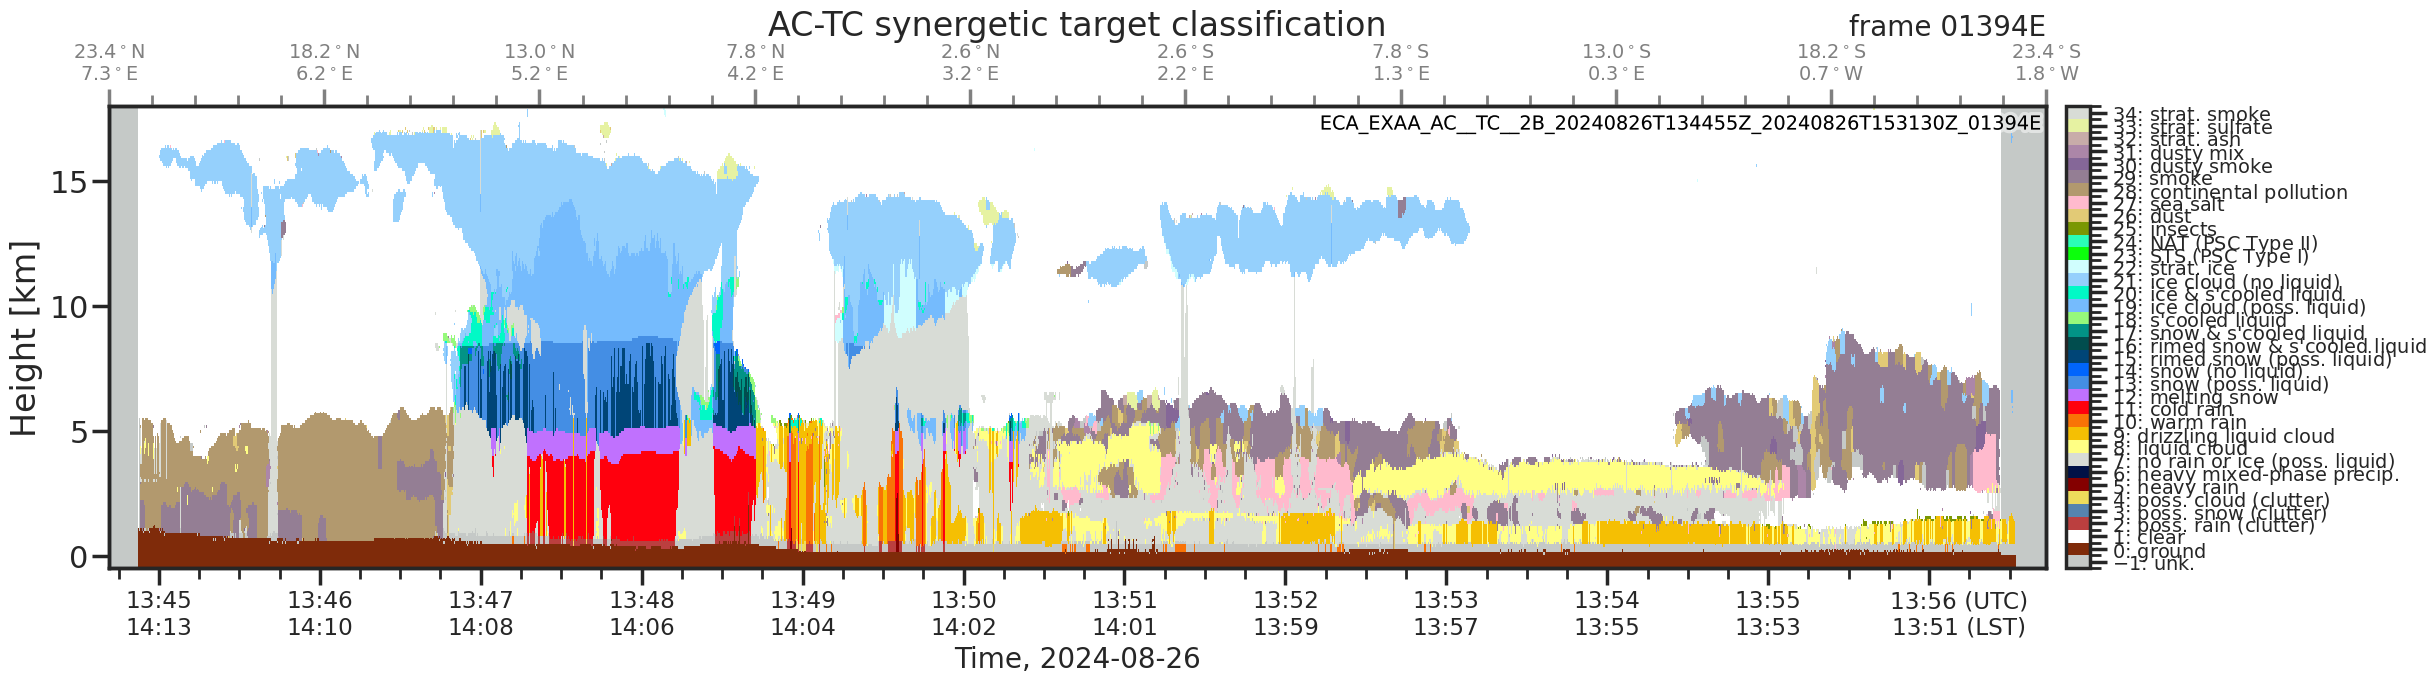

In [42]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(25,6), gridspec_kw={'hspace':0.8})
ecplt.plot_EC_target_classification(axes, ds, 'synergetic_target_classification', ACTC_category_colors, hmax=hmax)
plt.savefig('1394E.png')

In [44]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
href = href_lst[0]
with fs.open(href, "rb") as f:
    print(f)
    #ecio.load_ACTC(f)
    with xr.open_dataset(f, engine="h5netcdf", group="ScienceData") as ds:
        ds.load()

<File-like object HTTPFileSystem, https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/AC__TC__2B/AA/2024/08/26/ECA_EXAA_AC__TC__2B_20240826T133308Z_20240826T153030Z_01394D/ECA_EXAA_AC__TC__2B_20240826T133308Z_20240826T153030Z_01394D/ECA_EXAA_AC__TC__2B_20240826T133308Z_20240826T153030Z_01394D.h5>


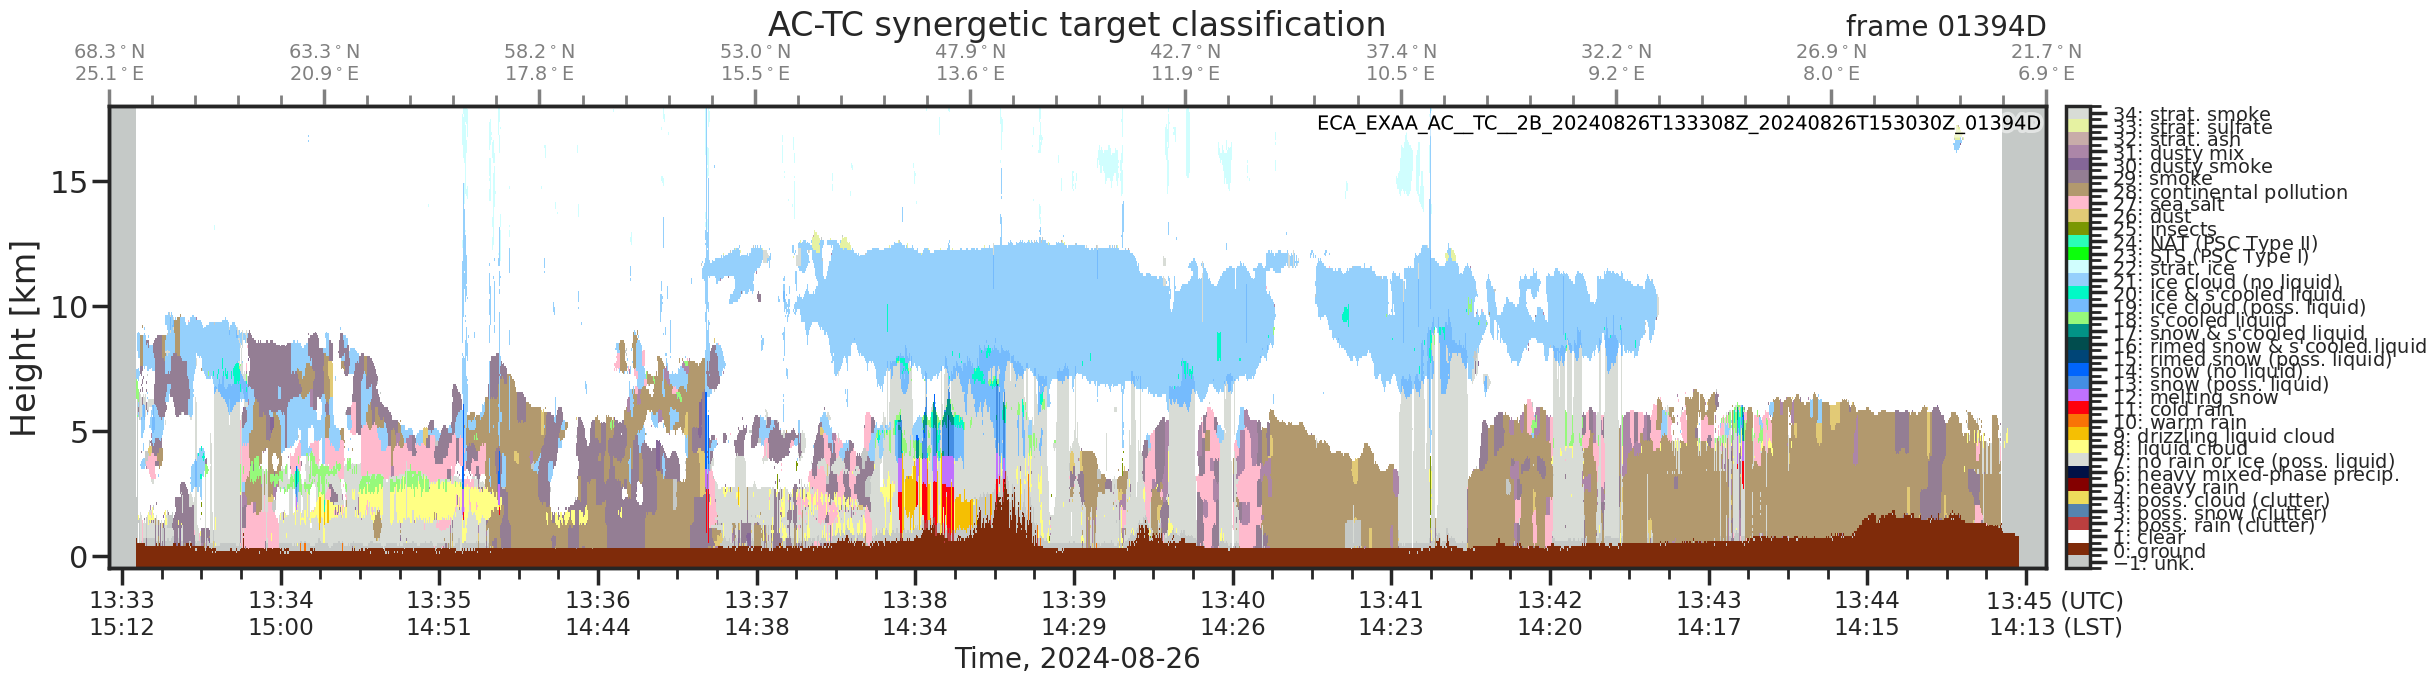

In [45]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(25,6), gridspec_kw={'hspace':0.8})
ecplt.plot_EC_target_classification(axes, ds, 'synergetic_target_classification', ACTC_category_colors, hmax=hmax)
plt.savefig('01394D.png')